# DisCoCat in DisCoPy

## Pregroup grammars

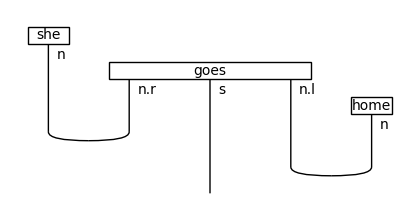

In [3]:
from discopy.grammar.pregroup import Cap, Cup, Id, Ty, Word

n, s = Ty('n'), Ty('s')

words = [
    Word('she', n),
    Word('goes', n.r @ s @ n.l),
    Word('home', n)
]

cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

assert Id().tensor(*words) == words[0] @ words[1] @ words[2]
assert Ty().tensor(*[n.r, s, n.l]) == n.r @ s @ n.l

diagram = Id().tensor(*words) >> cups
diagram.draw(figsize=(4, 2))

Before normal form: [Word('she', grammar.pregroup.Ty(rigid.Ob('n'))), Word('goes', grammar.pregroup.Ty(rigid.Ob('n', z=1), rigid.Ob('s'), rigid.Ob('n', z=-1))), Word('home', grammar.pregroup.Ty(rigid.Ob('n'))), grammar.pregroup.Cup(grammar.pregroup.Ty(rigid.Ob('n')), grammar.pregroup.Ty(rigid.Ob('n', z=1))), grammar.pregroup.Cup(grammar.pregroup.Ty(rigid.Ob('n', z=-1)), grammar.pregroup.Ty(rigid.Ob('n')))]
After normal form: [Word('she', grammar.pregroup.Ty(rigid.Ob('n'))), Word('goes', grammar.pregroup.Ty(rigid.Ob('n', z=1), rigid.Ob('s'), rigid.Ob('n', z=-1))), Word('home', grammar.pregroup.Ty(rigid.Ob('n'))), grammar.pregroup.Cup(grammar.pregroup.Ty(rigid.Ob('n')), grammar.pregroup.Ty(rigid.Ob('n', z=1))), grammar.pregroup.Cup(grammar.pregroup.Ty(rigid.Ob('n', z=-1)), grammar.pregroup.Ty(rigid.Ob('n')))]


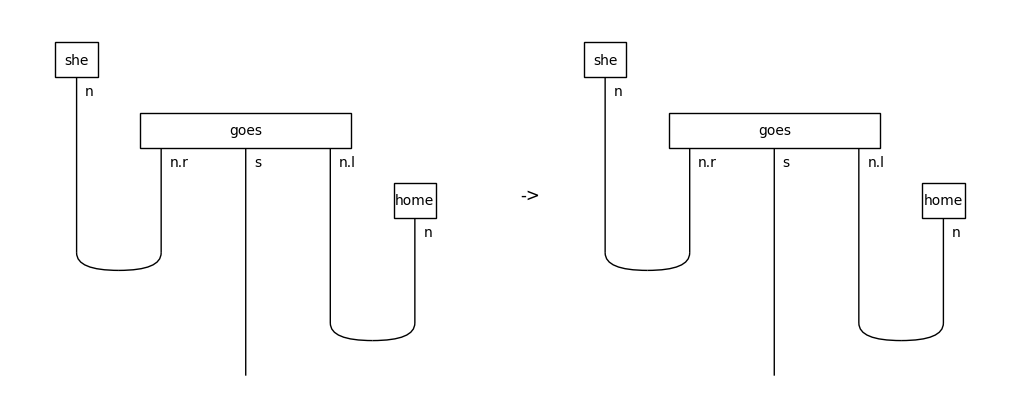

In [6]:
from discopy.drawing.legacy import Equation
from pytest import raises

# In the original diagram, words appear before the cups
print("Before normal form:", diagram.boxes)

diagram_nf = diagram.normal_form()
print("After normal form:", diagram_nf.boxes)

Equation(diagram, diagram_nf, symbol='->').draw(figsize=(10, 4))

# In the normalised diagram, boxes are not in the right order
# anymore, so cannot be drawn using grammar.draw()
# with raises(ValueError):
#     diagram_nf.draw(figsize=(4, 2))

## Functors

### Example 1: "Very" functor

In [7]:
from lambeq import BobcatParser
parser = BobcatParser(verbose='suppress')

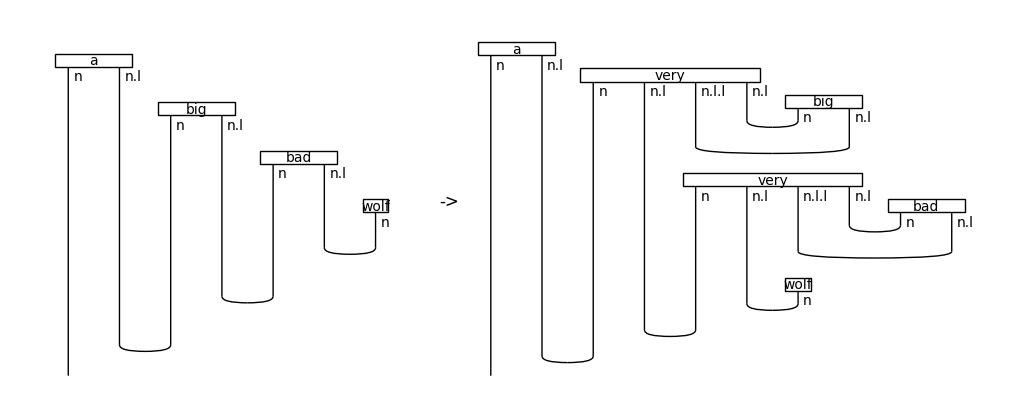

In [9]:
from discopy.grammar.pregroup import Diagram, Functor

# determiners have the same type as adjectives
# but we shouldn't add 'very' behind them
determiners = ['a', 'the', 'my', 'his', 'her', 'their']

# type for an adjective
adj = n @ n.l
very = Word('very', adj @ adj.l)
cups = Diagram.cups(adj.l, adj)

def very_ob(ty):
    return ty

def very_ar(box):
    if box != very:
        if box.name not in determiners:
            if box.cod == adj:
                return very @ box >> Id(adj) @ cups
    return box

very_functor = Functor(ob=very_ob, ar=very_ar)

diagram = parser.sentence2diagram('a big bad wolf')
new_diagram = very_functor(diagram)

Equation(diagram, new_diagram, symbol='->').draw(figsize=(10, 4))

### Example 2: Twist functor

In [10]:
from discopy.grammar.pregroup import Diagram, Functor

def twist_ob(ty):
    return ty

def twist_ar(box):
    return box

class TwistedDiagram(Diagram):
    @staticmethod
    def cups(left, right):
        swaps = Diagram.swap(left, right)
        cups = Diagram.cups(right, left)
        return swaps >> cups

    @staticmethod
    def caps(left, right):
        return TwistedDiagram.cups(left, right).dagger()


twist_functor = Functor(ob=twist_ob, ar=twist_ar, ar_factory=TwistedDiagram)

diagram = parser.sentence2diagram('This is twisted')
new_diagram = twist_functor(diagram)

diagram.draw(figsize=(4, 2))
new_diagram.draw(figsize=(4, 2))

snake = Id(n) @ Cap(n.r, n) >> Cup(n, n.r) @ Id(n)
Equation(twist_functor(snake), Id(n), symbol='=').draw(figsize=(4, 2))

TypeError: __init__() got an unexpected keyword argument 'ar_factory'

## Classical DisCoCat: Tensor networks

Dim(1) @ Dim(2) @ Dim(3)=Dim(2, 3)


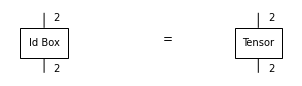

[[1 0]
 [0 1]]


In [6]:
from discopy.tensor import Box, Tensor, Id, Dim

# Dim(1) is the unit object, so disappears when tensored with another Dim
print(f'{Dim(1) @ Dim(2) @ Dim(3)=}')

id_box = Box('Id Box', Dim(2), Dim(2), data=[1,0,0,1])
id_tensor = Tensor(Dim(2), Dim(2), array=[1,0,0,1])

# the actual values of id_box and id_tensor are equal
assert (id_box.array == id_tensor.array).all()
drawing.equation(id_box, id_tensor, figsize=(4, 1))
print(id_box.array)

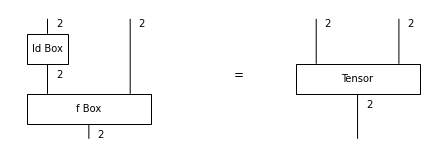

Tensor(dom=Dim(2, 2), cod=Dim(2), array=[0., 1., 2., 3., 4., 5., 6., 7.])
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]


In [7]:
f_box = Box('f Box', Dim(2, 2), Dim(2), data=range(8))
f_tensor = Tensor(Dim(2, 2), Dim(2), array=range(8))

combined_diagram = id_box @ Id(Dim(2)) >> f_box
combined_tensor = id_tensor @ Tensor.id(Dim(2)) >> f_tensor

# tensor diagram evaluates to the tensor
assert combined_diagram.eval() == combined_tensor
drawing.equation(combined_diagram, combined_tensor, figsize=(6, 2))
print(combined_tensor)
print(combined_tensor.array)

In [8]:
Tensor.cups(Dim(3), Dim(3)).array

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [9]:
Tensor.swap(Dim(2), Dim(2)).array

array([[[[1., 0.],
         [0., 0.]],

        [[0., 0.],
         [1., 0.]]],


       [[[0., 1.],
         [0., 0.]],

        [[0., 0.],
         [0., 1.]]]])

In [10]:
from discopy.tensor import Functor
import numpy as np

def one_ob(ty):
    dims = [2] * len(ty)
    return Dim(*dims) # does Dim(2,2,..)

def one_ar(box):
    dom = one_ob(box.dom)
    cod = one_ob(box.cod)
    tensor = np.ones(dom @ cod)
    print(f'"{box}" becomes')
    print(tensor)
    return tensor

one_functor = Functor(ob=one_ob, ar=one_ar)
one_functor(diagram)

"This" becomes
[1. 1.]
"is" becomes
[[[[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]]


 [[[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]]]
"twisted" becomes
[[1. 1.]
 [1. 1.]]


Tensor(dom=Dim(1), cod=Dim(2), array=[8., 8.])

## Quantum DisCoCat: Quantum circuits

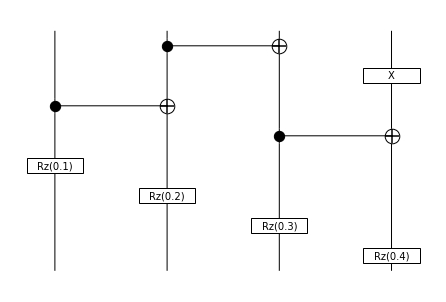

tk.Circuit(4).CX(1, 2).X(3).CX(0, 1).CX(2, 3).Rz(0.2, 0).Rz(0.4, 1).Rz(0.6, 2).Rz(0.8, 3)

In [11]:
from discopy.quantum import qubit, Id
from discopy.quantum.gates import CX, Rz, X

circuit = Id(4)
circuit >>= Id(1) @ CX @ X
circuit >>= CX @ CX
circuit >>= Rz(0.1) @ Rz(0.2) @ Rz(0.3) @ Rz(0.4)

# from discopy 0.4.1, can do:
same_circuit = (Id(4).CX(1, 2).X(3).CX(0, 1).CX(2, 3)
                .Rz(0.1, 0).Rz(0.2, 1).Rz(0.3, 2).Rz(0.4, 3))
assert circuit == same_circuit

circuit.draw()
circuit.to_tk()

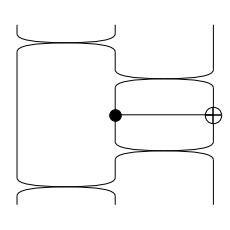

tk.Circuit(3).CX(2, 0)

In [12]:
from discopy import Circuit
from discopy.quantum.gates import SWAP

# to apply a CNOT on qubits 2 and 0:
circuit1 = Id(3)
circuit1 >>= SWAP @ Id(1)
circuit1 >>= Id(1) @ SWAP
circuit1 >>= Id(1) @ CX
circuit1 >>= Id(1) @ SWAP
circuit1 >>= SWAP @ Id(1)

# or you can do
perm = Circuit.permutation([2, 0, 1], inverse=True)
circuit2 = perm >> Id(1) @ CX >> perm[::-1]

assert circuit1 == circuit2
circuit1.draw(figsize=(3, 3))

# no swaps introduced when converting to tket
circuit1.to_tk()

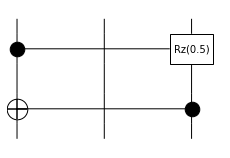

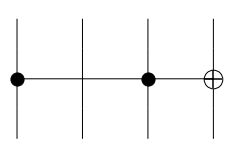

In [13]:
from discopy.quantum import Controlled, Rz, X
(Controlled(Rz(0.5), distance=2) >> Controlled(X, distance=-2)).draw(figsize=(3, 2))
Controlled(Controlled(X), distance=2).draw(figsize=(3, 2))

In [14]:
from discopy import Discard, Measure, Ket
from discopy import C, Q

print(C(Dim(2)) @ Q(Dim(2, 3)) @ C(Dim(2)))

print(Discard().eval())
print(Measure().eval())
print(Ket(0).eval())
# circuits that have measurements in them are no longer unitary
# and return CQMaps
print((Ket(0) >> Measure()).eval())

C(Dim(2, 2)) @ Q(Dim(2, 3))
CQMap(dom=Q(Dim(2)), cod=CQ(), array=[1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])
CQMap(dom=Q(Dim(2)), cod=C(Dim(2)), array=[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])
Tensor(dom=Dim(1), cod=Dim(2), array=[1.+0.j, 0.+0.j])
CQMap(dom=CQ(), cod=C(Dim(2)), array=[1.+0.j, 0.+0.j])


In [15]:
CX.eval(mixed=True)

CQMap(dom=Q(Dim(2, 2)), cod=Q(Dim(2, 2)), array=[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

In [16]:
print(CX.eval().array.shape)
print(CX.eval(mixed=True).array.shape)

(2, 2, 2, 2)
(2, 2, 2, 2, 2, 2, 2, 2)


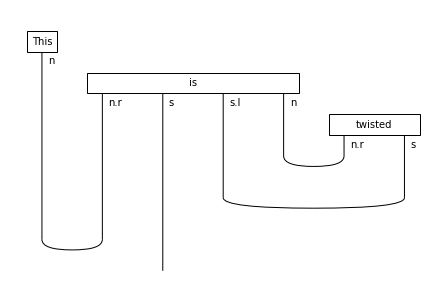

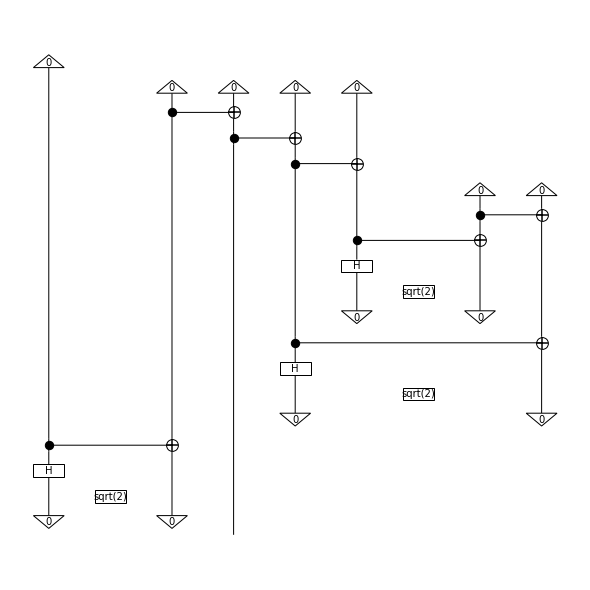

In [17]:
from discopy.quantum.circuit import Functor, Id

def cnot_ob(ty):
    # this implicitly maps all rigid types to 1 qubit
    return qubit ** len(ty)

def cnot_ar(box):
    dom = len(box.dom)
    cod = len(box.cod)
    width = max(dom, cod)
    circuit = Id(width)
    for i in range(width - 1):
        circuit >>= Id(i) @ CX @ Id(width - i - 2)

    # Add Bras (post-selection) and Kets (states)
    # to get a circuit with the right amount of
    # input and output wires
    if cod <= dom:
        circuit >>= Id(cod) @ Bra(*[0]*(dom - cod))
    else:
        circuit <<= Id(dom) @ Ket(*[0]*(cod - dom))
    return circuit

cnot_functor = Functor(ob=cnot_ob, ar=cnot_ar)
diagram.draw()
cnot_functor(diagram).draw(figsize=(8, 8))